<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Double descent

**Week 2, Day 1: Macrocircuits**

**By Neuromatch Academy**

__Content creators:__ Andrew Saxe, Vidya Muthukumar

__Content reviewers:__ Max Kanwal, Surya Ganguli, Xaq Pitkow, Hlib Solodzhuk, Patrick Mineault, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Alex Murphy

___

# Tutorial Objectives

*Estimated timing of tutorial: 1 hour*

In this tutorial, we'll look at the sometimes surprising behavior of large neural networks, which is called double descent. This empirical phenomenon puts the classical understanding of the bias-variance tradeoff in question: in double descent, highly overparametrized models can display good performance. In particular, we will explore the following:

- notions of low/high bias/variance
- improvement of test performance with the network's overparameterization, which leads to large model trends
- the conditions under which double descent is observed and what affects its significance
- the conditions under which double descent does not occur
  
Let's jump in!

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "9n4fj"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/9n4fj/


---
# Setup

In [2]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D1_T2"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [3]:
# @title Imports

import numpy as np
import matplotlib.pyplot as plt
import logging
import torch
from tqdm.notebook import tqdm as tqdm

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_fit(x_train, y_train, x_test, y_test, y_pred = 0):
    """
    Plot train and test data (as well as predicted values for test if given).

    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    """
    with plt.xkcd():
        plt.plot(x_test, y_test,label='Test data')
        plt.plot(x_train, y_train,'o',label='Training data')
        if y_pred:
            plt.plot(x_test, y_pred, label='Prediction')
        plt.legend()
        plt.xlabel('Input Feature')
        plt.ylabel('Target Output')

def predict(x_train, y_train, x_test, y_test, n_hidden = 10, reg = 0):
    """
    Plot predicted values for test set.
    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.
    - reg (float, default = 0): regularization term.
    """
    y_pred = fit_relu_implemented(x_train, y_train, x_test, y_test, n_hidden, reg)[2]

    with plt.xkcd():
        plt.plot(x_test, y_test,linewidth=4,label='Test data')
        plt.plot(x_train, y_train,'o',label='Training data')
        plt.plot(x_test, y_pred, color='g', label='Prediction')
        plt.xlabel('Input Feature')
        plt.ylabel('Target Output')
        plt.title('Number of Hidden Units = {}'.format(n_hidden))
        plt.show()

In [6]:
# @title Helper functions

def sin_dataset(sigma = 0):
    """
    Create a sinusoidal dataset and sample 10 points from it for a training dataset.
    Training set incorporates Gaussian noise added to the target values of the given standard deviation.

    Inputs:
    - sigma (float, default = 0): standard deviation of the train noise.

    Outputs:
    - x_train, y_train, x_test, y_test (tuple of np.ndarray): train and test data.
    """

    # Create a sinusoidal dataset and sample 10 points from it for a training dataset
    x_test = np.linspace(-np.pi, np.pi, 100)
    y_test = np.sin(x_test)

    x_train = np.linspace(-np.pi, np.pi, 10)
    # y_train = np.sin(x_train) + 0.05 * np.random.normal(size=10)
    y_train = np.sin(x_train) + sigma * np.random.normal(size=10)

    return x_train.reshape(10,1), y_train.reshape(10,1), x_test.reshape(100,1), y_test.reshape(100,1)

def fit_relu_implemented(x_train, y_train, x_test, y_test, n_hidden = 10, reg = 0):
    """
    Fit the second layer of the network by solving via linear regression for the given training data and evaluate the performance.

    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): the size of the hidden layer.
    - reg (float, default = 0): regularization term.

    Outputs:
    - train_err (float): train error value.
    - test_err (float): test error value.
    - y_pred (np.ndarray): array of predicted values for test data.
    """

    # Define network architecture
    n_inputs = 1  # Number of input features
    n_outputs = 1  # Number of output units

    # Layer 1 (Input -> Hidden)
    W1 = np.random.normal(0, 1, (n_inputs, n_hidden))  # Random weights
    b1 = np.random.uniform(-np.pi, np.pi, size = (1, n_hidden))  # Bias

    # Layer 2 (Hidden -> Output)
    W2 = np.zeros((n_hidden, n_outputs))  # Initialize weights to zero

    # Forward propagation
    def forward_prop(X):
        z1 = X.dot(W1) + b1
        a1 = np.maximum(0, z1)  # ReLU activation
        z2 = a1.dot(W2)
        return z2

    # Fit second layer weights with linear regression
    hidden = np.maximum(0, x_train.dot(W1) + b1)  # Hidden layer activations
    if reg == 0:
        # Pseudo-inverse solution
        hidden_pinv = np.linalg.pinv(hidden)
        W2 = hidden_pinv.dot(y_train)
    else:
        # We use linalg.solve to find the solution to (H'H + reg*I) * W2 = H'y,
        # equivalent to W2 = (H'H + reg*I)^(-1) * H'y
        W2 = np.linalg.solve(hidden.T @ hidden + reg * np.eye(n_hidden), hidden.T @ y_train)

    # Train Error
    y_pred = forward_prop(x_train)
    train_err = np.mean((y_train-y_pred)**2/2)

    # Test Error
    y_pred = forward_prop(x_test)
    test_err = np.mean((y_test-y_pred)**2/2)

    return train_err, test_err, y_pred


def fit_relu_init_scale(x_train, y_train, x_test, y_test, init_scale = 0, n_hidden = 10, reg = 0):
    """
    Fit the second layer of the network by solving for linear regression with pseudo-inverse for the given training data and evaluate the performance on test one.

    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - init_scale (float, default = 0): initial standard deviation for weights in the second layer.
    - n_hidden (int, default = 10): the size of the hidden layer.
    - reg (float, default = 0): regularization term.

    Outputs:
    - train_err (float): train error value.
    - test_err (float): test error value.
    - y_pred (np.ndarray): array of predicted values for test data.
    """

    # Define network architecture
    n_inputs = 1  # Number of input features
    n_outputs = 1  # Number of output units

    # Layer 1 (Input -> Hidden)
    W1 = np.random.normal(0,1, (n_inputs, n_hidden))  # Random weights
    b1 = np.random.uniform(-np.pi, np.pi, size=(1, n_hidden))  # Bias

    # Layer 2 (Hidden -> Output)
    W2 = np.random.normal(0,init_scale,(n_hidden, n_outputs))  # Initialize weights to zero

    # Forward propagation
    def forward_prop(X):
        z1 = X.dot(W1) + b1
        a1 = np.maximum(0, z1)  # ReLU activation
        z2 = a1.dot(W2)
        return z2

    # Fit second layer weights with linear regression
    hidden = np.maximum(0, x_train.dot(W1) + b1)  # Hidden layer activations
    if reg == 0:
        hidden_pinv = np.linalg.pinv(hidden)
        W2 = hidden_pinv.dot(y_train) + (np.eye(n_hidden) - hidden_pinv @ hidden) @ W2   # Pseudo-inverse solution plus component in data nullspace
    else:
        hidden_pinv = np.dot(np.linalg.pinv(np.dot(hidden.T, hidden) + reg*np.eye(n_hidden)), hidden.T)
        W2 = hidden_pinv.dot(y_train) + (np.eye(n_hidden) - hidden_pinv @ hidden) @ W2   # Pseudo-inverse solution plus component in data nullspace

    # Train Error
    y_pred = forward_prop(x_train)
    train_err = np.mean((y_train-y_pred)**2/2)

    # Test Error
    y_pred = forward_prop(x_test)
    test_err = np.mean((y_test-y_pred)**2/2)

    return train_err, test_err, y_pred

def sweep_test_init_scale(x_train, y_train, x_test, y_test, init_scale = 0, n_hidden = 10, n_reps = 20):
    """
    Calculate the mean test error for fitting the second layer of the network for a defined number of repetitions.
    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - init_scale (float, default = 0): initial standard deviation for weights in the second layer.
    - n_hidden (int, default = 10): size of hidden layer.

    Outputs:
    - (float): mean error for test data.
    """
    return np.mean(np.array([fit_relu_init_scale(x_train, y_train, x_test, y_test, init_scale=init_scale, n_hidden=n_hidden)[1] for i in range(n_reps)]))

def sweep_train(x_train, y_train, x_test, y_test, n_hidden = 10, n_reps = 20):
    """
    Calculate the mean train error for fitting the second layer of the network for a defined number of repetitions.
    Notice that `init_scale` is always set to be 0 in this case.
    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.

    Outputs:
    - (float): mean error for train data.
    """
    return np.mean(np.array([fit_relu(x_train, y_train, x_test, y_test, n_hidden=n_hidden)[0] for i in range(n_reps)]))

In [7]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

In [8]:
# @title Video 1: Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'BAQYcMpqtYU'), ('Bilibili', 'BV1Q4421S7St')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [9]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introduction")

---
# Section 1: Overfitting in overparameterized models

In this section we will observe the classical behaviour of overparametrized networks: overfitting. This is where a model becomes tuned specifically to the features of the training data, beyond the general patterns. For example, if data points are measured with an imperfect system that introduces noise into the recording values, then overfitting can be thought of as a model that learns the signal **and** the noise associated with each data point, instead of just the **signal**. This is characterized by a low training error and a higher test error.

In [10]:
# @title Video 2: Overfitting in Overparameterized Models

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'z3n1fT76gHs'), ('Bilibili', 'BV1gi421i7DP')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_overfitting_in_overparameterized_models")

## Coding Exercise 1: Learning with a simple neural network

We start by generating a simple sinusoidal dataset.

This dataset contains 100 data points. We've selected a subset of 10 points for training.

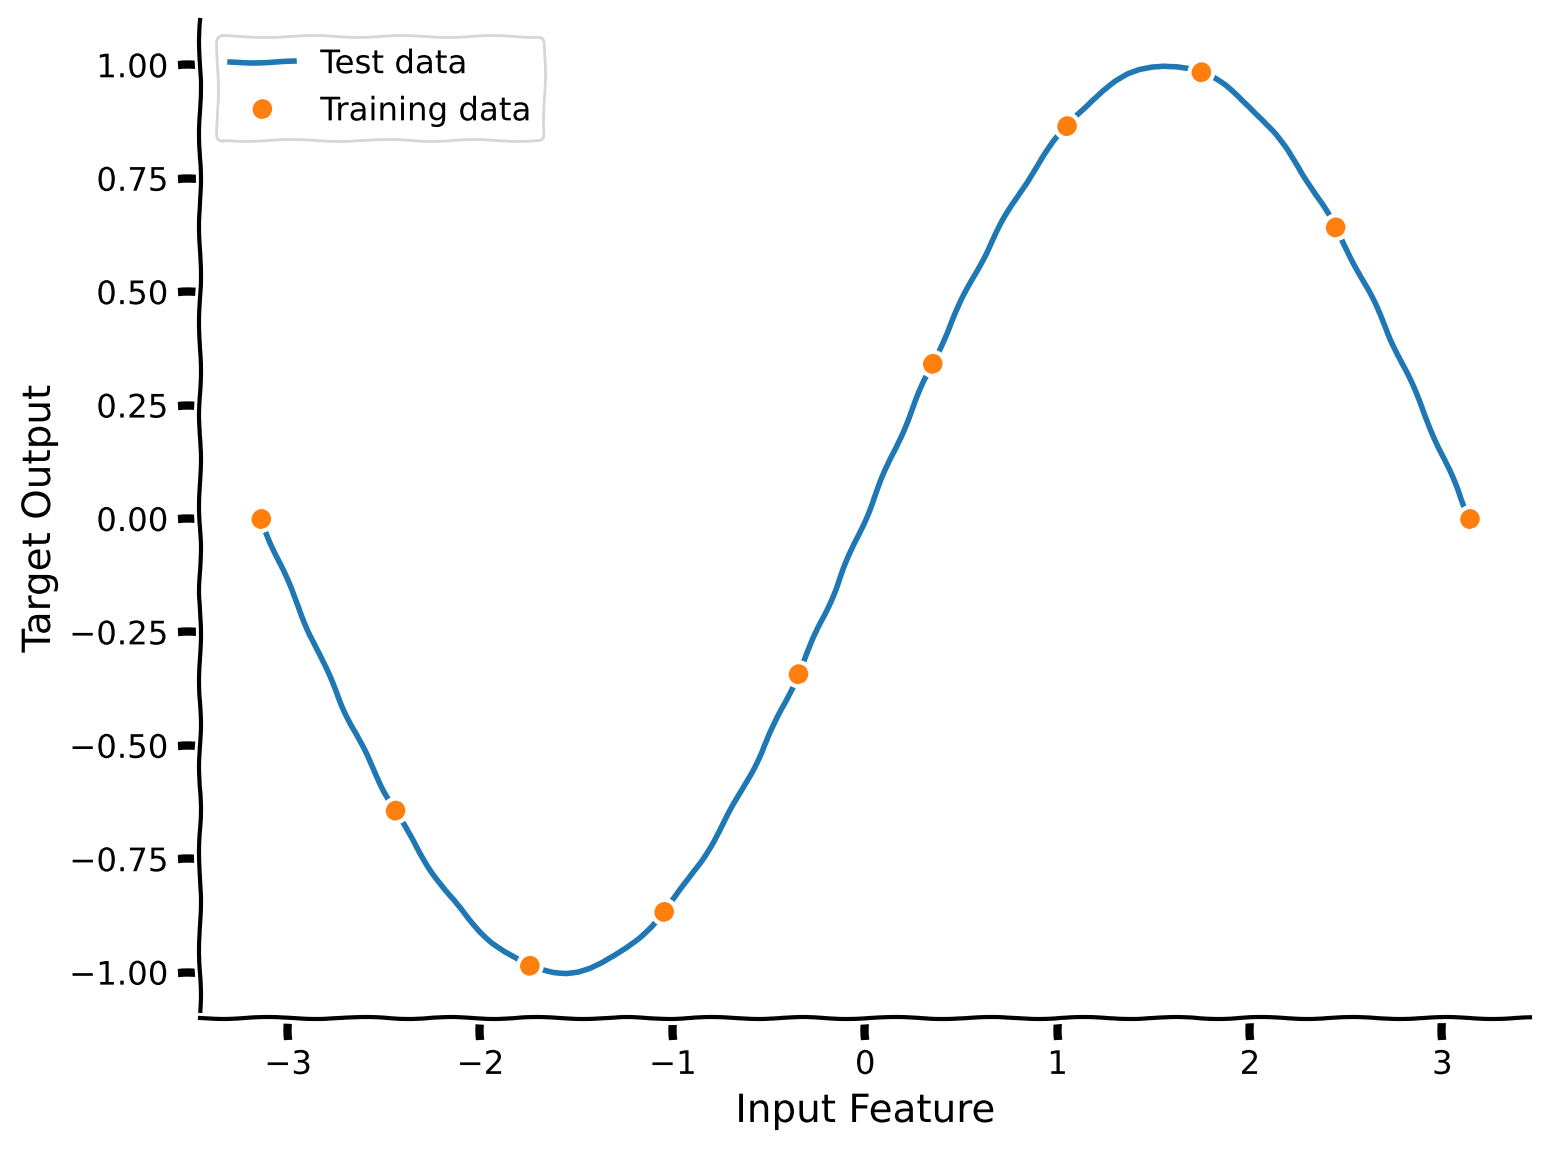

In [11]:
# @title Sample and plot sinusoidal dataset

set_seed(42)
x_train, y_train, x_test, y_test = sin_dataset()

plot_fit(x_train, y_train, x_test, y_test)

We'll learn this task with a simple neural network: a one-hidden-layer ReLU network, where the first layer is fixed and random.

That is, the network computes its hidden activity as $h = ReLU(W_1x + b)$, and its output as $\hat y = W_2h$.

The input $x\in R$ is a scalar. There are $N_h$ hidden units, and the output $\hat y\in R$ is a scalar.

We will initialize $W_1$ with i.i.d. random Gaussian values with a variance of `1.0` and $b$ with values drawn i.i.d. uniformly between $-\pi$ and $\pi$. Finally, we will initialize the weights $W_2$ to `0`.

We only train $W_2$, leaving $W_1$ and $b$ fixed. We can train $W_2$ to minimize the mean squared error between the training labels $y$ and the network's output on those datapoints.

Usually, we would train this network using gradient descent, but here, we've taken advantage of the fixed first layer to compute the solution in closed form using linear regression. This is much faster than gradient descent, allowing us to us rapidly train many networks.

<details open>
<summary> Closed-form solution derivation (optional)</summary>
<br>

To find $W_2$, we will rewrite the problem in matrix form. Let:
- $X$ be the matrix of input data (shape $ n \times 1 $)
- $H$ be the matrix of hidden activations after ReLU (shape $ n \times N_h $)
- $y$ be the vector of target outputs (shape $n \times 1$)

$W_1$, $W_2$ and $b$ are of shape $N_h \times 1$.

Compute the hidden activations:

$$
H = \text{ReLU}(X W_1^\top + b)
$$

The predicted outputs can be written as:

$$
\hat{y} = H W_2
$$

We aim to minimize the mean squared error (MSE) between the predicted output $\hat{y}$ and the true output $y$:

$$
\mathcal{L} = \text{MSE} = (H W_2 - y)^2
$$

By taking the derivative of this expression by $W_2$, we get:

$$
\frac{\partial \mathcal{L}}{\partial W_2} = 0 = 2H^\top HW_2 - 2H^\top y
$$

Meaning that the optimal solution $W_2$ is:

$$
W_2 = H^+ y
$$

Here, $H^+$ is the [Moore-Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse).

</details>


Below is the skeleton code for this network. Your task is to implement its weight initialization and forward pass function. In the cell below, you can test your solution.

In [16]:

def fit_relu(x_train, y_train, x_test, y_test, n_hidden = 10, reg = 0):
    """
    Fit the second layer of the network by solving via linear regression for the given training data and evaluate the performance.

    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): the size of the hidden layer.
    - reg (float, default = 0): regularization term.

    Outputs:
    - train_err (float): train error value.
    - test_err (float): test error value.
    - y_pred (np.ndarray): array of predicted values for test data.
    """

    # Define network architecture
    n_inputs = 1  # Number of input features
    n_outputs = 1  # Number of output units

    # Layer 1 (Input -> Hidden)
    W1 = np.random.normal(0, 1, (n_inputs, n_hidden))  # Random weights
    b1 = np.random.uniform(-np.pi, np.pi, size = (1, n_hidden))  # Bias

    # Layer 2 (Hidden -> Output)
    W2 = np.zeros((n_hidden, n_outputs))  # Initialize weights to zero

    # Forward propagation
    def forward_prop(X):
        z1 = X.dot(W1) + b1
        a1 = np.maximum(0, z1)  # ReLU activation
        z2 = a1.dot(W2)
        return z2

    # Fit second layer weights with linear regression
    hidden = np.maximum(0, x_train.dot(W1) + b1)  # Hidden layer activations
    if reg == 0:
        # Pseudo-inverse solution
        hidden_pinv = np.linalg.pinv(hidden)
        W2 = hidden_pinv.dot(y_train)
    else:
        # We use linalg.solve to find the solution to (H'H + reg*I) * W2 = H'y,
        # equivalent to W2 = (H'H + reg*I)^(-1) * H'y
        W2 = np.linalg.solve(hidden.T @ hidden + reg * np.eye(n_hidden), hidden.T @ y_train)

    # Train Error
    y_pred = forward_prop(x_train)
    train_err = np.mean((y_train-y_pred)**2/2)

    # Test Error
    y_pred = forward_prop(x_test)
    test_err = np.mean((y_test-y_pred)**2/2)

    return train_err, test_err, y_pred

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial2_Solution_dd90b43d.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_learning_with_simple_neural_network")

## Coding Exercise 2: The Bias-Variance Trade-off

With the network implemented, we now investigate how the size of the network (the number of hidden units it has, $N_h$) relates to its ability to generalize.

Ultimately, the true measure of a learning system is how well it performs on novel inputs, that is, its ability to generalize. The classical story of how model size relates to generalization is captured in the concept of the bias-variance tradeoff. We assume you are familiar with this concept already. If not, take some time to discuss in your group or search out a verified explanation to review.

To start, complete the code below to train several small networks with just two hidden neurons and plot their predictions.

In [17]:

def fit_relu(x_train, y_train, x_test, y_test, n_hidden = 10, reg = 0):
    """
    Fit the second layer of the network by solving via linear regression for the given training data and evaluate the performance.

    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): the size of the hidden layer.
    - reg (float, default = 0): regularization term.

    Outputs:
    - train_err (float): train error value.
    - test_err (float): test error value.
    - y_pred (np.ndarray): array of predicted values for test data.
    """

    # Define network architecture
    n_inputs = 1  # Number of input features
    n_outputs = 1  # Number of output units

    # Layer 1 (Input -> Hidden)
    W1 = np.random.normal(0, 1, (n_inputs, n_hidden))  # Random weights
    b1 = np.random.uniform(-np.pi, np.pi, size = (1, n_hidden))  # Bias

    # Layer 2 (Hidden -> Output)
    W2 = np.zeros((n_hidden, n_outputs))  # Initialize weights to zero

    # Forward propagation
    def forward_prop(X):
        z1 = X.dot(W1) + b1
        a1 = np.maximum(0, z1)  # ReLU activation
        z2 = a1.dot(W2)
        return z2

    # Fit second layer weights with linear regression
    hidden = np.maximum(0, x_train.dot(W1) + b1)  # Hidden layer activations
    if reg == 0:
        # Pseudo-inverse solution
        hidden_pinv = np.linalg.pinv(hidden)
        W2 = hidden_pinv.dot(y_train)
    else:
        # We use linalg.solve to find the solution to (H'H + reg*I) * W2 = H'y,
        # equivalent to W2 = (H'H + reg*I)^(-1) * H'y
        W2 = np.linalg.solve(hidden.T @ hidden + reg * np.eye(n_hidden), hidden.T @ y_train)

    # Train Error
    y_pred = forward_prop(x_train)
    train_err = np.mean((y_train-y_pred)**2/2)

    # Test Error
    y_pred = forward_prop(x_test)
    test_err = np.mean((y_test-y_pred)**2/2)

    return train_err, test_err, y_pred

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial2_Solution_e1136bc5.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial2_Solution_e1136bc5_0.png>



With just two hidden units, the model cannot fit the training data, nor the test data. A network of this size has **high bias**.

Now, let's train a network with five hidden units.

### Coding Exercise 2 Discussion

1. Do you expect the network to fit the data better with five hidden units than with two units? Check your intuition by running the cell below.

In [19]:
# @title Observe the performance on 5 hidden units
set_seed(42)

n_hid = 5
n_reps = 10

plot_predictions(n_hid, n_reps)

NameError: name 'plot_predictions' is not defined

With five hidden units, the model can do a better job of fitting the training data, and also follows the test data more closely, though still with errors.

Next let's try 10 hidden units. Try to visualize how you might think the plot before running the cell below.

In [20]:
# @title Observe the performance on 10 hidden units
set_seed(42)

n_hid = 10
n_reps = 10

plot_predictions(n_hid, n_reps)

NameError: name 'plot_predictions' is not defined

With 10 hidden units, the network often fits every training datapoint, but generalizes poorly--sometimes catastrophically so. We say that this size network has high variance. Intuitively, it is so complex that it can fit the training data perfectly, but this same complexity means it can take many different shapes in between datapoints.

We have just traced out the bias-variance tradeoff: the models with 2 hidden units had high bias, while the models with 10 hidden units had high variance. The models with 5 hidden units struck a balance--they were complex enough to achieve relatively low error on the training data points, but simple enough to be well constrained by the training data. The best choice of neural network architecture (e.g. choosing the number of neurons in a layer) is therefore highly dependent on the structure of the problem you are trying to solve and the format of the input data. It also involves trying out a few values and checking for where on the bias-variance trade-off line you find yourself. This was extremely important in classical approaches to understanding how to develop good neural networks. That was then, we are now in the **Modern Regime**, which we'll move on to now!

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_bias_variance_tradeoff")

---
# Section 2: The Modern Regime

Estimated timing to here from start of tutorial: 20 minutes

In this section, we will go beyond ten hidden units, which might sound unreasonable, but it will result in an unexpected plot twist.

In [21]:
# @title Video 3: Modern Regime

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'uYqWdoC0TrM'), ('Bilibili', 'BV13r421w7gS')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_modern_regime")

We just saw that a network with 10 hidden units trained on 10 training data points could fail to generalize. If we add even more hidden units, it seems unlikely that the network could perform well. How could hundreds of weights be correctly constrained when we just showed that these ten data points failed to capture any meaningful relationship of the training data?

Let's go crazy and train a network with `500` hidden units and see what happens!

In [ ]:
# @title Observe the performance on 500 hidden units
set_seed(42)

n_hid = 500
n_reps = 10

plot_predictions(n_hid, n_reps)

## Coding Exercise 3: Observing double descent

Remarkably, this very large network fits the training data points and generalizes well. We've managed to get predictions that look like they have learned the distribution of our input data correctly.

This network has fifty times as many parameters as data points. How can this be?

We have tested four different network sizes (`2`, `5`, `10`, `500`) and we saw the qualitative behavior of the predictions. Now, let's systematically compute the average test error for different network sizes.

For each network size in the array below, train 100 networks and plot their mean test error.

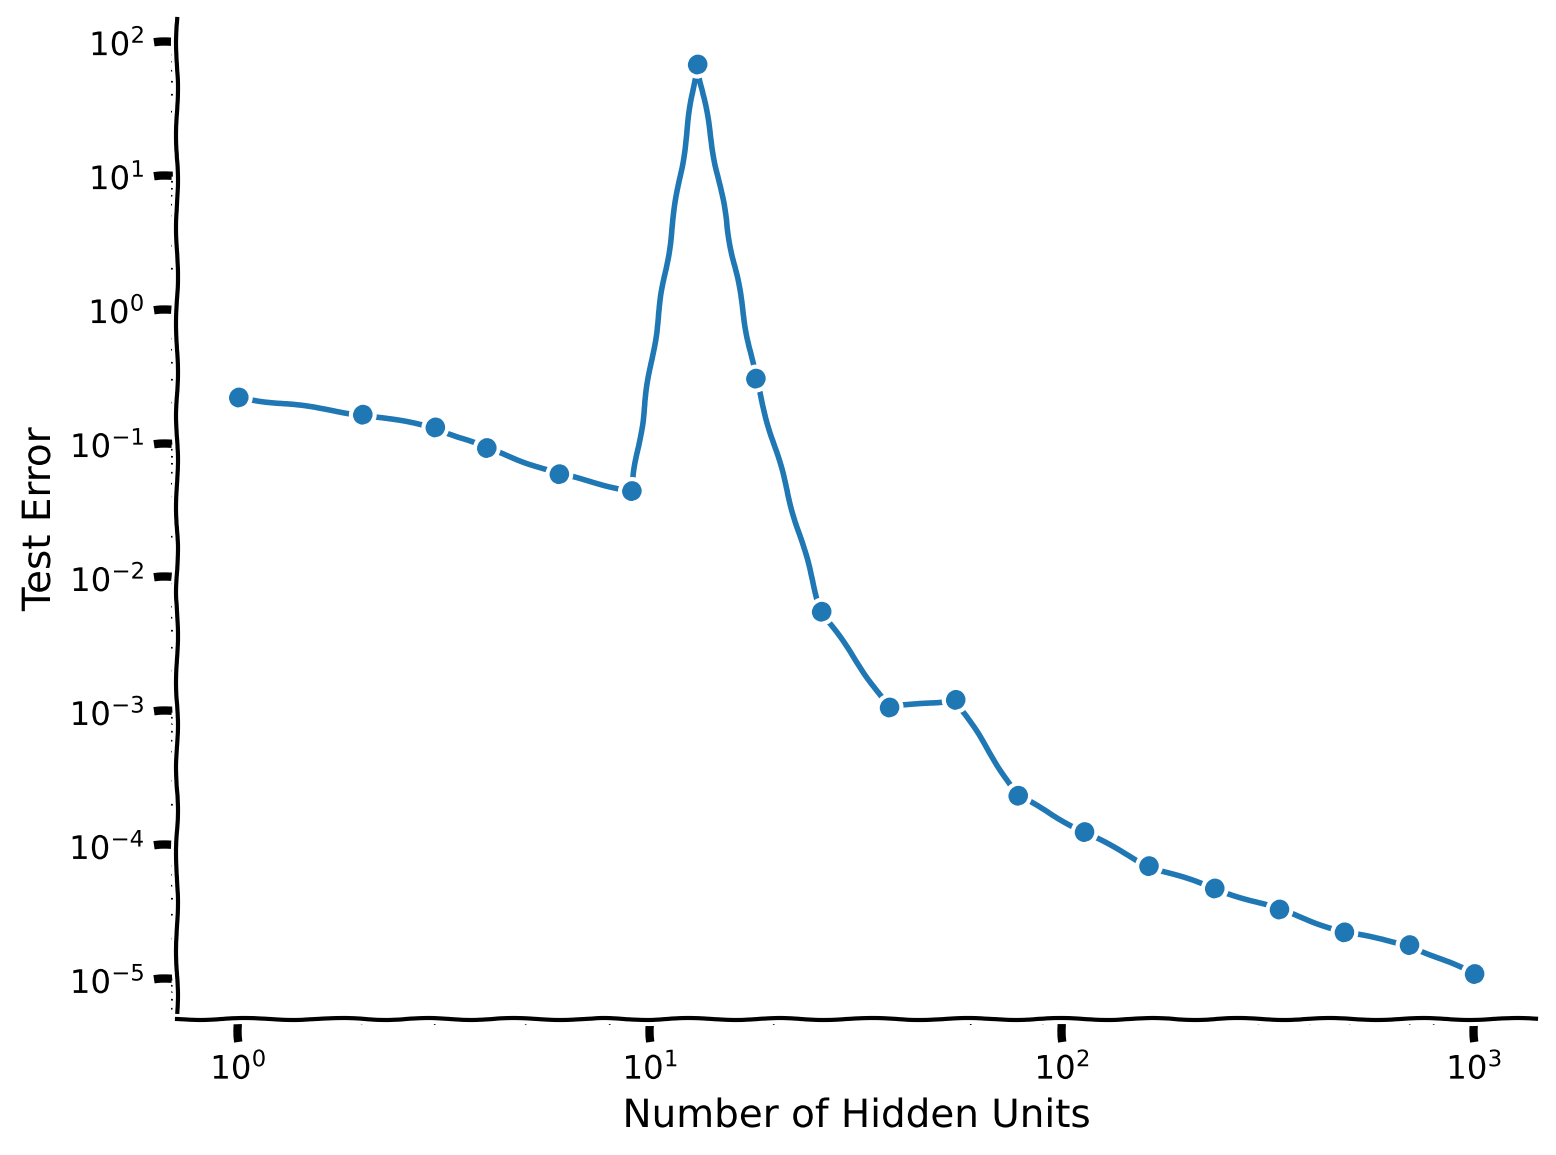

In [22]:
set_seed(42)

n_hids = np.unique(np.round(np.logspace(0, 3, 20))).astype(int)

def sweep_test(x_train, y_train, x_test, y_test, n_hidden = 10, n_reps = 100, reg = 0.0):
    """
    Calculate the mean test error for fitting the second layer of the network for a defined number of repetitions.
    Notice that `init_scale` is always set to 0 in this case.
    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.
    - n_reps (int, default = 100): number of resamples for data.
    - reg (float, default = 0): regularization constant.

    Outputs:
    - (float): mean error for train data.
    """
    return np.mean(np.array([fit_relu(x_train, y_train, x_test, y_test, n_hidden=n_hidden, reg = reg)[1] for _ in range(n_reps)]))

test_errs = [sweep_test(x_train, y_train, x_test, y_test, n_hidden=n_hid, n_reps=100, reg = 0.0) for n_hid in n_hids]

with plt.xkcd():
    plt.loglog(n_hids,test_errs,'o-',label='Test')
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Test Error')
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial2_Solution_7717ab4f.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial2_Solution_7717ab4f_0.png>



This curve is an example of the **double descent phenomenon**: between 1 hidden unit and 10 hidden units, we see the bias-variance tradeoff (containing the first descent). The test error reaches its peak at 10 hidden units. Then it descends again (hence double descent), eventually outperforming the smaller models.

Hence, in this scenario, larger models perform better--even when they contain many more parameters than datapoints.

The peak (worst generalization) is at an intermediate model size when the number of hidden units is equal to the number of examples in this case. More generally, it turns out the peak occurs when the model first becomes complex enough to reach zero training error. This point is known as the **interpolation threshold**.

The trend for deep learning models growing in size is in part due to the implications of the phenomenon of double descent. But does it always hold? Let's now see where its limits are and what modulates the ability to learn in this overparameterized regime.

## Interactive Demo 1: Interpolation point & predictions

In this interactive demo, you have a slider that represents the number of hidden units in a network to be trained on and then we bserve one representative trial of predicted values.

In [23]:
# @title Execute this cell to observe interactive plot

set_seed(42)

@widgets.interact
def interactive_predict(n_hid = widgets.IntSlider(description="Hidden Units", min=0, max=300, step=1, value=5)):
    predict(x_train, y_train, x_test, y_test, n_hidden = n_hid)

interactive(children=(IntSlider(value=5, description='Hidden Units', max=300), Output()), _dom_classes=('widge…

Having experimented with this interactive tool for a little while, are you able to see the relationship between the results shown here and the double descent plot above (the previous figure)?

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_observing_double_descent")


---
# Section 3: Double Descent, Noise & Regularization

*Estimated timing to here from start of tutorial: 35 minutes*

In this section, we are going to explore the effect of noise and regularization on double descent.

In [24]:
# @title Video 4: Noise & Regularization Effects

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'lCeJmCDcSc0'), ('Bilibili', 'BV1ms421u7Zc')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [25]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_noise_regularization_effects")

## Coding Exercise 4: Noise & regularization impact

So far, our training data points have been noiseless. Intuitively, a noisy training dataset might hurt the ability of complex models to generalize. In this section, we are going to explore the effect of noise on double descent behavior.

Let's test this. Add i.i.d. Gaussian noise of different standard deviations to the training labels, and plot the resulting double descent curves.

  0%|          | 0/3 [00:00<?, ?it/s]

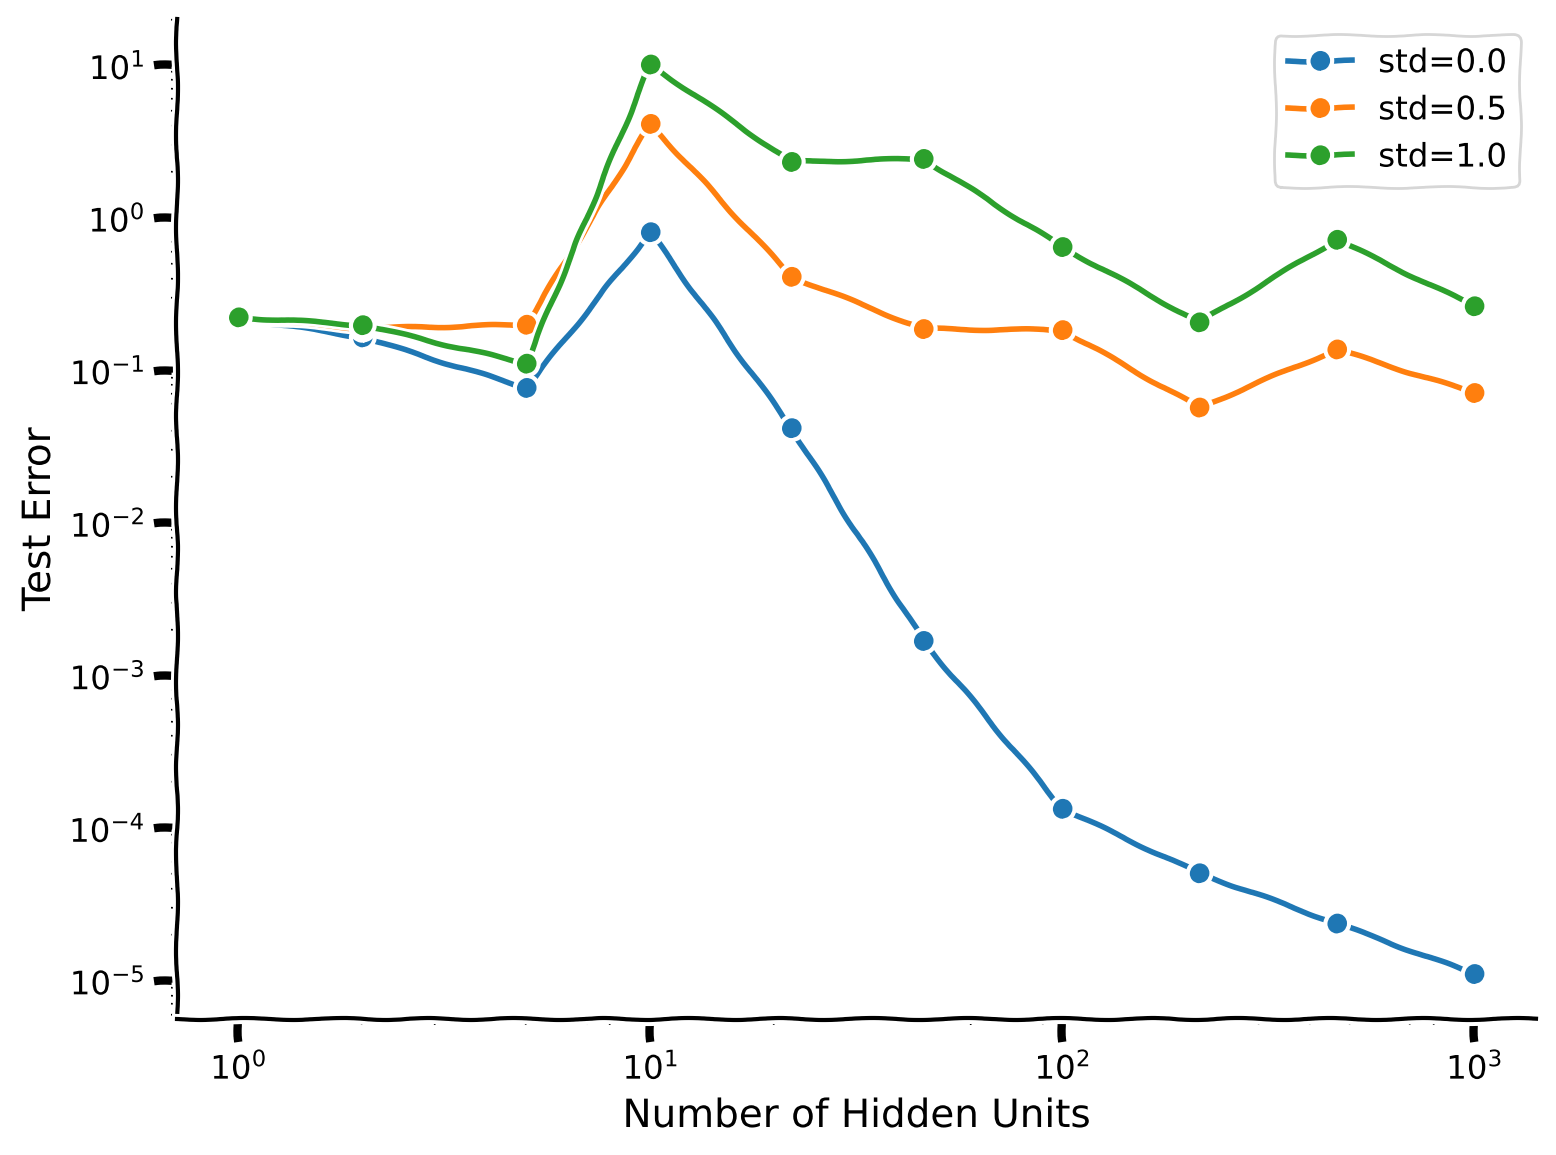

In [26]:
set_seed(42)

n_hids = np.unique(np.round(np.logspace(0, 3, 10))).astype(int)

std_devs = np.linspace(0, 1.0, 3)

def plot_error(x_train, y_train, x_test, y_test, std_devs, n_hids, n_hidden = 10, n_reps = 100, reg = 0.0):
    """
    Plot mean test error for distinct values of noise added to train dataset.

    Inputs:
    - x_train (np.ndarray): train input data.
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - std_devs (np.ndarray): different standard deviation values for noise.
    - n_hids (np.ndarray): different values for hidden layer size.
    - n_hidden (int, default = 10): size of hidden layer.
    - n_reps (int, default = 100): number of resamples for data.
    - reg (float, default = 0): regularization constant.
    """
    with plt.xkcd():
        for sd in tqdm(std_devs):
            test_errs = [sweep_test(x_train, y_train + np.random.normal(0,sd,y_train.shape), x_test, y_test, n_hidden = n_hid, n_reps = n_reps, reg = reg * (1 + sd)) for n_hid in n_hids]
            plt.loglog(n_hids,test_errs,'o-',label="std={}".format(sd))

        plt.legend()
        plt.xlabel('Number of Hidden Units')
        plt.ylabel('Test Error')
        plt.show()

plot_error(x_train, y_train, x_test, y_test, std_devs, n_hids)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial2_Solution_00f64733.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial2_Solution_00f64733_1.png>



Though we are still able to observe the effect of double descent, its nowhere near as clear when we introduce noise into the training data.

Thus far, we have examined the impact of number of parameters without any explicit regularization (in which case we saw that all models with > 10 parameters fit all training data including noise). What happens if we add in explicit regularization to prevent overfitting? Let's take a look. We'll add L2 regularization to the weights of the network, also known as weight decay or Tikhonov regularization. The closed form solution for $\mathbf{W}_2$ with L2 regularization is:

$$\mathbf{W}_2 = (\mathbf{H}^\top \mathbf{H} + \lambda \mathbf{I})^{-1} \mathbf{H}^\top \mathbf{y}$$

where $\lambda$ is the regularization strength.

  0%|          | 0/3 [00:00<?, ?it/s]

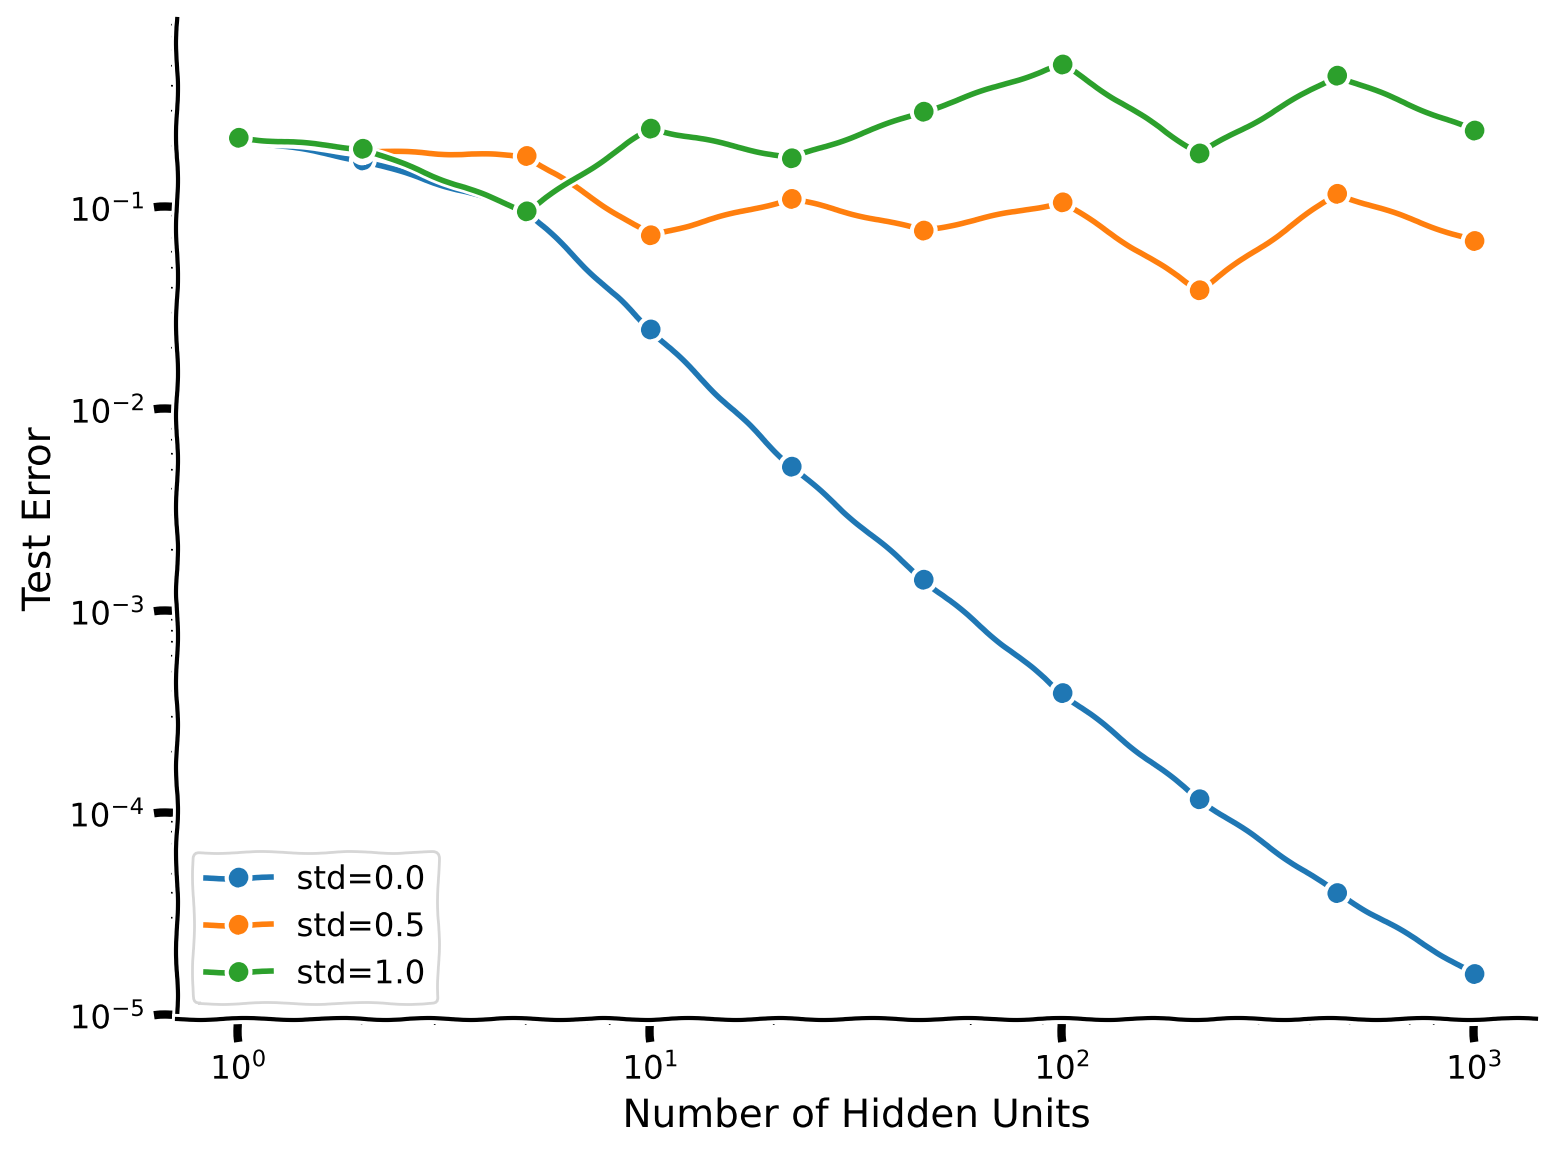

In [27]:
# @title Observe the error plots with regularization term included
set_seed(42)

plot_error(x_train, y_train, x_test, y_test, std_devs, n_hids, reg=0.2)

We observe that the "peak" disappears, and the test error roughly monotonically decreases, although it is generally higher for higher noise levels in the training data.

<details open>
<summary> A note about the use of the term "regularization" in multiple contexts in ML (optional)</summary>
<br>
The word *regularization* is commonly used in statistics/ML parlance in two different contexts to ensure the good generalization of overparameterized models:

- The first context, which is emphasized throughout the tutorial, is explicit regularization which means that the model is not trained to completion (zero training error) in order to avoid overfitting of noise. Without explicit regularization, we observe the double descent behavior – i.e. catastrophic overfitting when the number of model parameters is too close to the number of training examples – but also a vast reduction in this overfitting effect as we heavily overparameterize the model. With explicit regularization (when tuned correctly), the double descent behavior disappears because we no longer run the risk of overfitting to noise at all.
- The second context is the one of inductive bias – overparameterized models, when trained with popular optimization algorithms like gradient descent, tend to converge to a particularly “simple” solution that perfectly fits the data. By “simple”, we usually mean that the size of the parameters (in terms of magnitude) is very small. This inductive bias is a big reason why double descent occurs as well, in particular, the benefit of overparameterization in reducing overfitting.
</details>

When our training labels contain noise, are larger models still always better than smaller ones? You may have to run the cell a few times because even with 100 repetitions, these estimates can have high variance.

Edit the code below to visualize a 500-hidden unit network's predictions for the case where the noise standard deviation is 0.2.

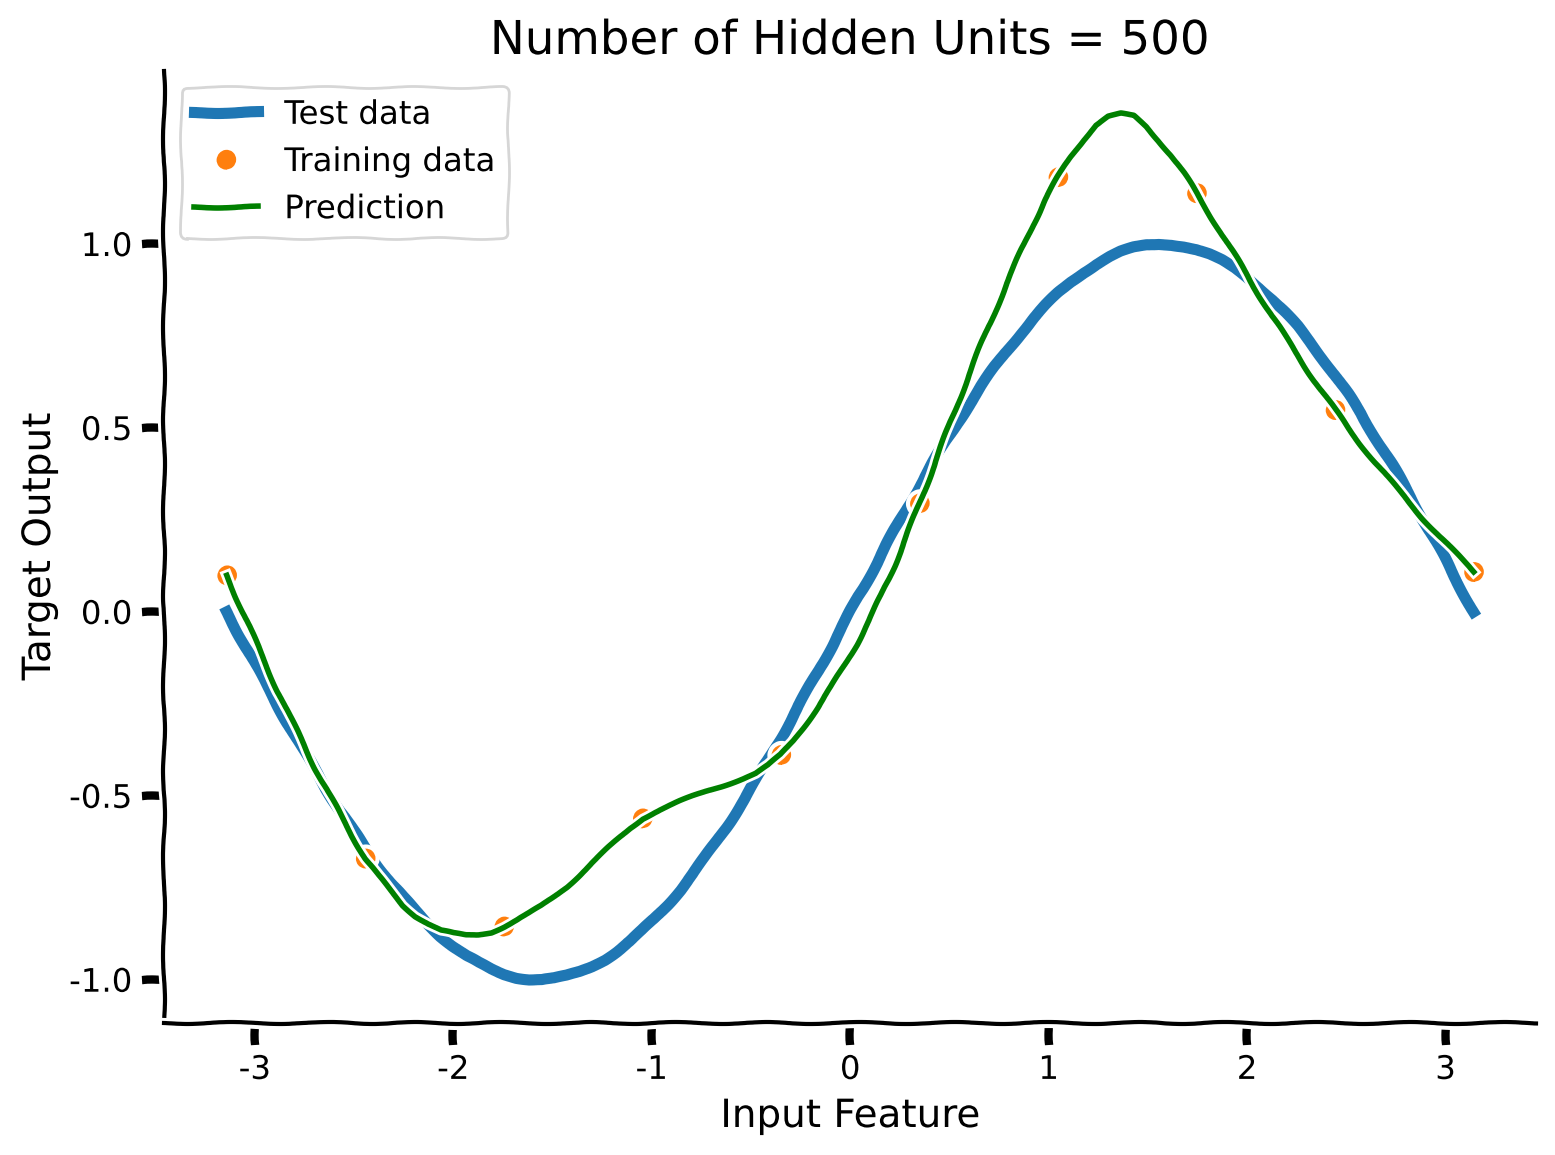

In [28]:
set_seed(42)

std_dev = .2

noise = np.random.normal(0, std_dev, y_train.shape)

n_hid = 500
n_reps = 10

with plt.xkcd():
    plt.plot(x_test, y_test,linewidth=4,label='Test data')
    plt.plot(x_train, y_train + noise,'o',label='Training data')
    train_err, test_err, y_pred = fit_relu(x_train, y_train + noise, x_test, y_test, n_hidden = n_hid)
    plt.plot(x_test, y_pred, color='g', label='Prediction')
    plt.legend()
    plt.xlabel('Input Feature')
    plt.ylabel('Target Output')
    plt.title('Number of Hidden Units = {}'.format(n_hid))
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial2_Solution_6d385a89.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial2_Solution_6d385a89_0.png>



The network smoothly interpolates between the training data points. Even when noisy, these can still somewhat track the test data. Depending on the noise level, though, a smaller and more constrained model can be better.

From this, we might expect that large models will work particularly well for datasets with little label noise. Many real world datasets fit this requirement: image classification datasets strive to have accurate labels for all data points, for instance. Other datasets may not. For instance, predicting DSM-V diagnoses from structural MRI data is a noisy task, as the diagnoses themselves are noisy due to the inherent difficulty of mapping observations to clinically defined classes.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_noise_regularization_impact")

---
# Section 4: Double Descent and Initialization

*Estimated timing to here from start of tutorial: 50 minutes*


So far, we have considered one important aspect of neural network architectures, namely the width of a hidden layer (the number of neurons in the layer). However, another critical aspect connected to the emergence of the double descent phenomenon is that of weight initialization. In the last tutorial, we explored weight initialization from the perspective of a chaotic and non-chaotic regime. We saw that low variance initialization of weights led some deep MLPs to exhibit transformations in the quasi-linear regime. Let's now explore what the effects of weight initialization are on the double descent phenomenon.

In [29]:
# @title Video 5: Initialization Scale

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'dVhk5orM9_c'), ('Bilibili', 'BV1i1421C7Z6')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [30]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_initialization_scale")

## Coding Exercise 5: Initialization scale impact

Instead of initializing the second layer weights $W_2$ to zero, we'll now initialize them with i.i.d. Gaussian elements with a specified standard deviation.

### Coding Exercise 5 Discussion

1. How does this change the double descent curve?
   
Notice that executing this cell will take around 3 minutes. Thus, we invite you to guess / predict what you are going to see while the cell is running.

  0%|          | 0/5 [00:00<?, ?it/s]

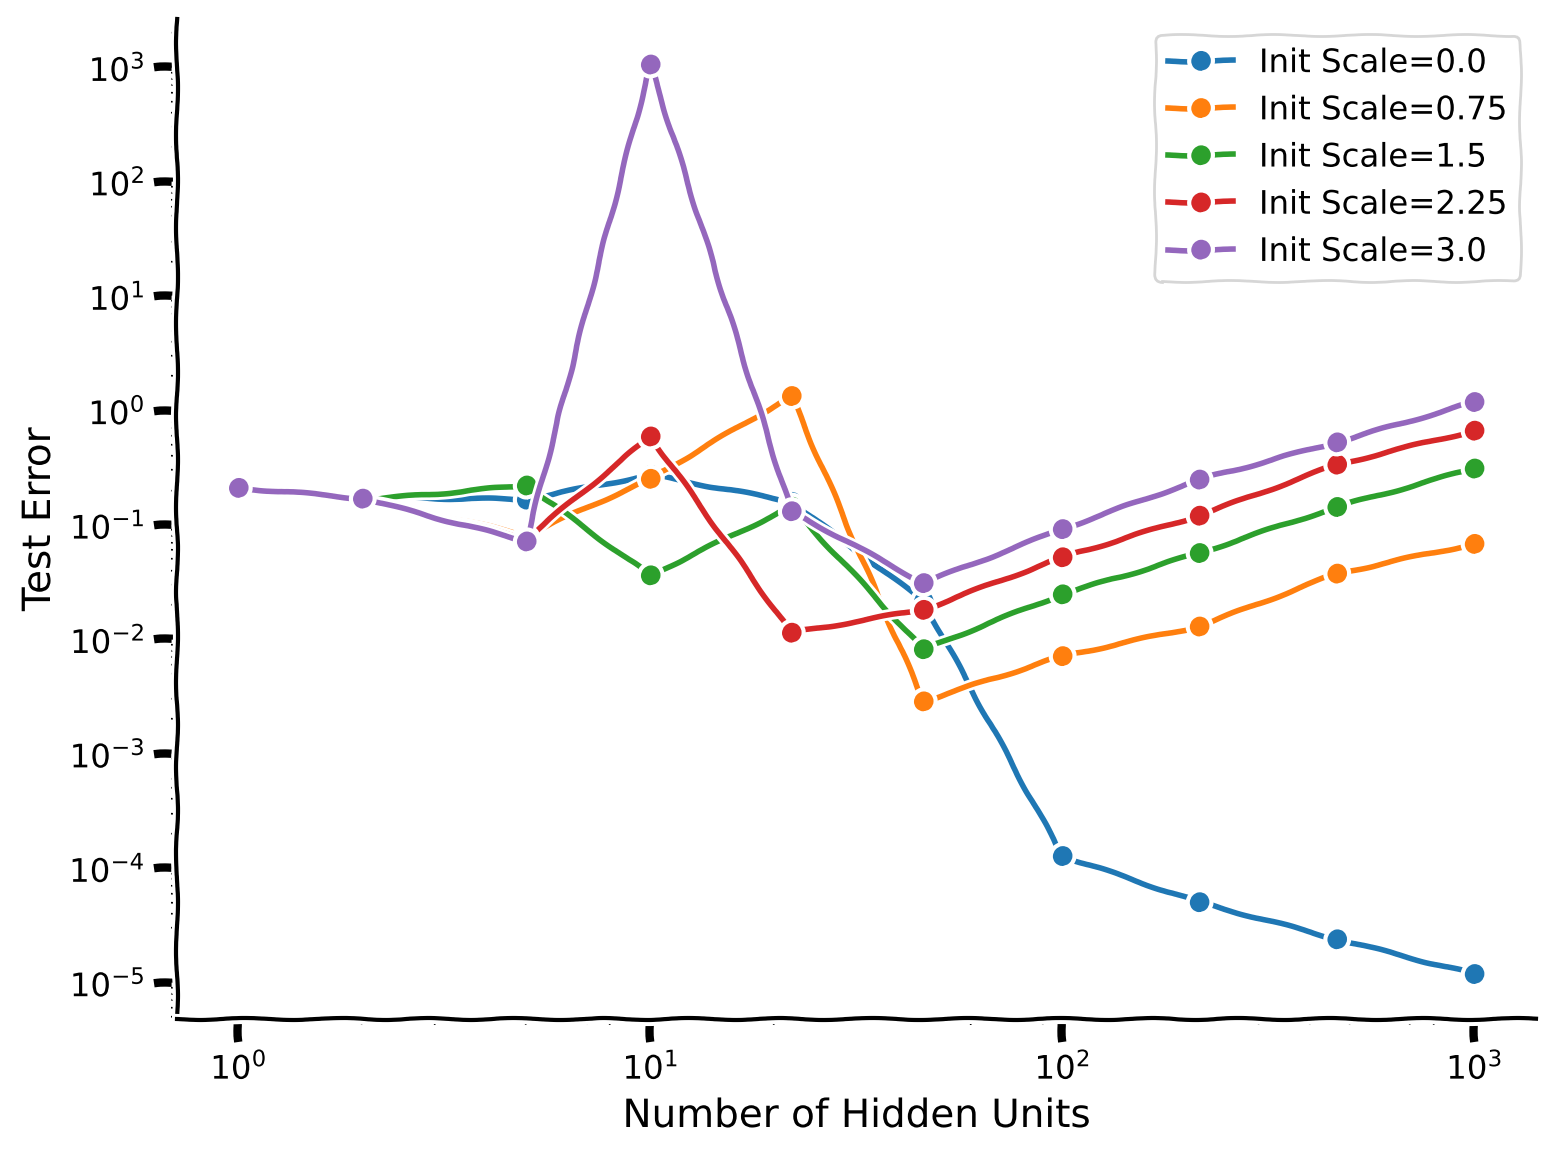

In [31]:
set_seed(42)
init_scales = np.linspace(0, 3, 5)

n_hids = np.unique(np.round(np.logspace(0, 3, 10))).astype(int)

with plt.xkcd():
    for sd in tqdm(init_scales):
        test_errs = [sweep_test_init_scale(x_train, y_train, x_test, y_test, init_scale = sd, n_hidden=n_hid, n_reps=100) for n_hid in n_hids]
        plt.loglog(n_hids,test_errs,'o-',label="Init Scale={}".format(sd))

    plt.legend()
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Test Error')
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial2_Solution_fd82f22a.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial2_Solution_fd82f22a_1.png>



We see that for our overparametrized model (where the number of parameters is larger than the number of training examples) the initialization scale strongly impacts the test error. The better performance of these large models thus depends on our choice of initializing $W_2$ equal to zero.

Intuitively, this is because directions of weight space in which we have no training data are not changed by gradient descent, so poor initialization can continue to affect the model even after training. Large initializations implement random functions that generalize poorly.

Let's see what the predictions of a large-variance-initialization network with 500 hidden neurons look like. We will set `init_scale = 1.0` in this example below.

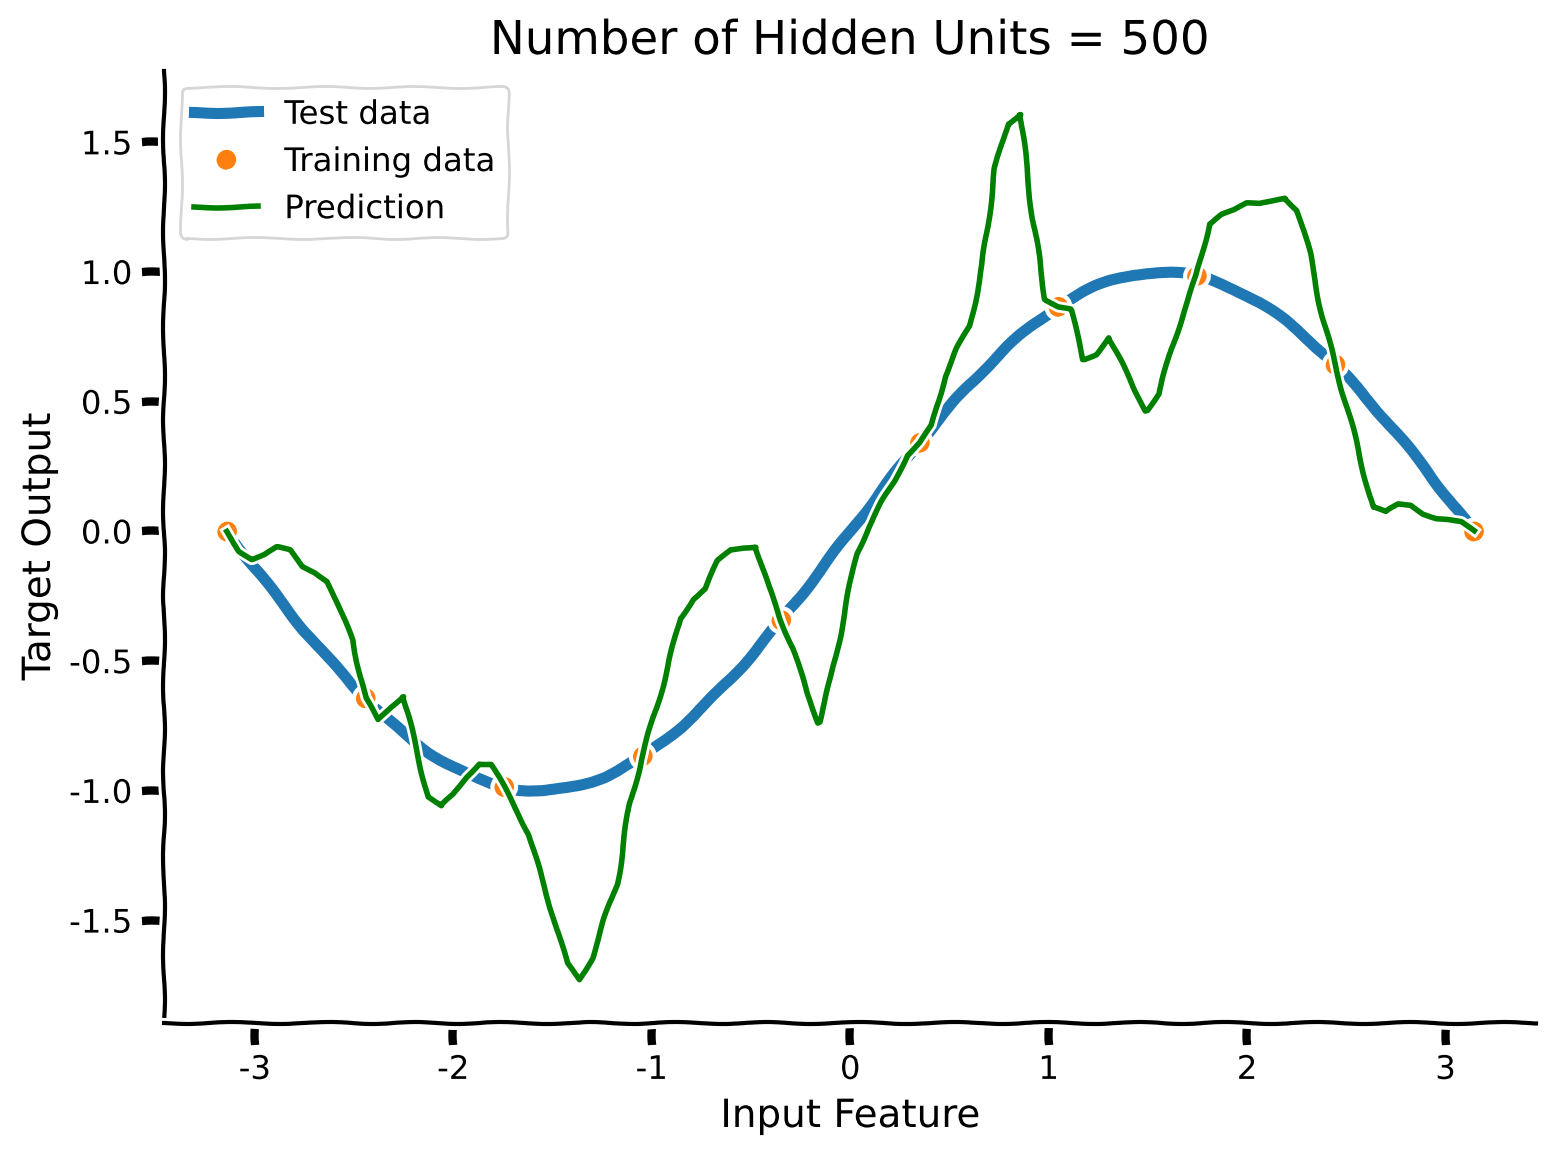

In [32]:
# @title Execute the cell to observe the plot
init_scale = 1

n_hid = 500

with plt.xkcd():
    plt.plot(x_test, y_test,linewidth=4,label='Test data')
    plt.plot(x_train, y_train,'o',label='Training data')
    train_err, test_err, y_pred = fit_relu_init_scale(x_train, y_train, x_test, y_test, init_scale=init_scale, n_hidden=n_hid)
    plt.plot(x_test, y_pred, color='g', label='Prediction')

    plt.legend()
    plt.xlabel('Input Feature')
    plt.ylabel('Target Output')
    plt.title('Number of Hidden Units = {}'.format(n_hid))
    plt.show()

The network perfectly fits every training datapoint, but now connects them with more complex functions.

Intuitively, in a large network, there are many ways to achieve zero training error. Gradient descent tends to find solutions that are near the initialization. So simple initializations (here, small variance) yield less complex models that can generalize well.

Therefore, proper initialization is critical for good generalization in large networks.

There is one more mathematical trick to highlight, used in `fit_relu_init_scale` to find the appropriate weights. This passage is optional for those who would like to dive into implementation specifics.
<details open>
<summary> Solution in case of non-zero weights initialization</summary>
    
The tutorial is trying to study what happens when you train the network with gradient descent for a very long time. However, if we actually trained these networks that way, it'd indeed take a very long time. So, we have picked a case where we know where training will end up and can calculate this endpoint in a different way. This case is basically a linear regression from the hidden layer activity. We have covered mathematical derivation at the very beginning of the tutorial.

Still, there's one case that is a bit trickier: what if the network is overparametrized? That is, what if we have fewer data samples than weights? Then, there are many possible solutions that can result in zero training errors. Starting from some particular initialization $w^0$, which one of these solutions will gradient descent end at? It turns out that the gradient descent dynamics only change the weights in the subspace spanned by the input training data. The component of the weights that start in the orthogonal complement of that subspace, the data null space, i.e., the subspace in which we have no data at all, doesn't change at all during gradient descent learning. So, whatever initial values the weights take in that subspace will persist throughout training. To see this, note that the gradient update is $\Delta w \propto \text{error} H^T$, so every update is in the direction of a training example. Therefore, to calculate $w^{\text{gd}}$, the weights that gradient descent reaches convergence, we need to add the component of the weight initialization that lies in this data nullspace to the minimum norm linear regression solution given by the earlier equation for $w$^. That is, $w^{gd} = w^ + (I-\text{pinv}(H)H)w^0$, where $w^0$ is the initial weight vector and $(I-\text{pinv}(H)H)$ is one way of calculating the projection of that vector into the data nullspace.

To recap the intuition: shallow gradient descent learning in overparameterized models has a *frozen subspace* in which weight components do not change during learning, and so initial values in this subspace persist forever. We have to add the projection of our initialization on this frozen subspace to the minimum norm linear regression solution to obtain the solution that gradient descent would find. New test examples can then overlap with this frozen subspace, making the network's test performance depend on the initial weights.


In [33]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_double_descent_initialization")

In [34]:
# @title Video 6: Summary

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '6V1MZBRxVlo'), ('Bilibili', 'BV1Gr421w745')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [35]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_summary")

---
# The Big Picture

*Estimated timing of tutorial: 1 hour*

In this tutorial, we observed the phenomenon of double descent: the situation when the overparameterized network was expected to behave as overfitted but instead generalized better to the unseen data. Moreover, we discovered how noise, regularization & initial scale impact the effect of double descent and, in some cases, can fully cancel it.

Combining with the findings from the first tutorial of the previous day on sparse connections and activity, brain architecture suggests it might operate in over parameterized regime, which enables the interpolation of vast amounts of sensory and experiential data smoothly, leading to effective generalization.